# 資料集
## https://www.kaggle.com/mhskjelvareid/dagm-2007-competition-dataset-optical-inspection

In [1]:
import cv2
from tqdm import tqdm 
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from robust_confusion_matrix import robust_confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Flatten, Dropout, Activation, Conv2D, MaxPooling2D,GlobalAveragePooling2D,BatchNormalization

In [3]:
img = cv2.imread('./DAGM_KaggleUpload/Class6/Train/0576.PNG')

In [4]:
img.shape

(512, 512, 3)

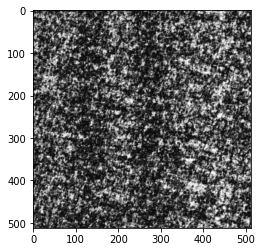

In [5]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [6]:
img = cv2.imread('./DAGM_KaggleUpload/Class6/Train/0579.PNG')

In [7]:
img.shape

(512, 512, 3)

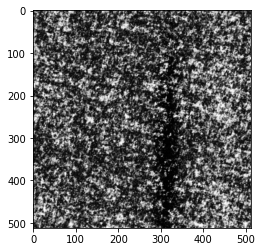

In [8]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# 產生data frame

In [9]:
import pandas as pd

In [10]:
df = pd.read_table('./DAGM_KaggleUpload/Class6/Train/Label/Labels.txt',sep='\t',header=0, names=['NG','img_name','0','NG_label','NaN'])
df

,NG,img_name,0,NG_label,NaN
576,0,0576.PNG,0,0,NaN
577,0,0577.PNG,0,0,NaN
578,0,0578.PNG,0,0,NaN
579,1,0579.PNG,0,0579_label.PNG,NaN
580,0,0580.PNG,0,0,NaN
...,...,...,...,...,...
1146,0,1146.PNG,0,0,NaN
1147,0,1147.PNG,0,0,NaN
1148,0,1148.PNG,0,0,NaN
1149,0,1149.PNG,0,0,NaN


In [11]:
df = df[['NG', 'img_name']]
df

,NG,img_name
576,0,0576.PNG
577,0,0577.PNG
578,0,0578.PNG
579,1,0579.PNG
580,0,0580.PNG
...,...,...
1146,0,1146.PNG
1147,0,1147.PNG
1148,0,1148.PNG
1149,0,1149.PNG


In [12]:
df['PASS'] = 1
df

,NG,img_name,PASS
576,0,0576.PNG,1
577,0,0577.PNG,1
578,0,0578.PNG,1
579,1,0579.PNG,1
580,0,0580.PNG,1
...,...,...,...
1146,0,1146.PNG,1
1147,0,1147.PNG,1
1148,0,1148.PNG,1
1149,0,1149.PNG,1


In [13]:
df['PASS'][df['NG'] ==1] = 0
df

,NG,img_name,PASS
576,0,0576.PNG,1
577,0,0577.PNG,1
578,0,0578.PNG,1
579,1,0579.PNG,0
580,0,0580.PNG,1
...,...,...,...
1146,0,1146.PNG,1
1147,0,1147.PNG,1
1148,0,1148.PNG,1
1149,0,1149.PNG,1


In [14]:
df_PASS = df_PASS = df[df['PASS'] == 1]
df_PASS

,NG,img_name,PASS
576,0,0576.PNG,1
577,0,0577.PNG,1
578,0,0578.PNG,1
580,0,0580.PNG,1
582,0,0582.PNG,1
...,...,...,...
1146,0,1146.PNG,1
1147,0,1147.PNG,1
1148,0,1148.PNG,1
1149,0,1149.PNG,1


In [15]:
df_NG = df[df['NG'] == 1]
df_NG

,NG,img_name,PASS
579,1,0579.PNG,0
581,1,0581.PNG,0
587,1,0587.PNG,0
598,1,0598.PNG,0
599,1,0599.PNG,0
...,...,...,...
1112,1,1112.PNG,0
1115,1,1115.PNG,0
1124,1,1124.PNG,0
1130,1,1130.PNG,0


In [16]:
df_train_PASS= df_PASS.sample(frac=0.9, random_state=33)
df_val_PASS = df_PASS.drop(df_train_PASS.index)

In [17]:
df_train_NG = df_NG.sample(frac=0.9, random_state=33)
df_val_NG = df_NG.drop(df_train_NG.index)

## PASS 跟 NG 資料不平衡

In [18]:
df_train_PASS.shape

(443, 3)

In [19]:
df_train_NG.shape

(75, 3)

In [20]:
# 資料不平衡，將訓練資料集中的NG複製5份
df_train = df_train_PASS
for _ in range(df_train_PASS.shape[0]//df_train_NG.shape[0] + 1):
    df_train = pd.concat([df_train, df_train_NG])
df_train

,NG,img_name,PASS
1132,0,1132.PNG,1
922,0,0922.PNG,1
639,0,0639.PNG,1
1088,0,1088.PNG,1
876,0,0876.PNG,1
...,...,...,...
785,1,0785.PNG,0
820,1,0820.PNG,0
868,1,0868.PNG,0
856,1,0856.PNG,0


In [21]:
df_val = pd.concat([df_val_PASS, df_val_NG], ignore_index=True)
df_val

,NG,img_name,PASS
0,0,0585.PNG,1
1,0,0595.PNG,1
2,0,0601.PNG,1
3,0,0604.PNG,1
4,0,0609.PNG,1
5,0,0615.PNG,1
6,0,0619.PNG,1
7,0,0651.PNG,1
8,0,0655.PNG,1
9,0,0660.PNG,1


## 資料擴增

In [22]:
input_size = (224,224)
batch_size = 32
epoch = 100
label = {'PASS':0, 'NG':1}
classes=['PASS','NG']
num_classes  = len(label)

In [23]:
path = './DAGM_KaggleUpload/Class6/Train/'

train_datagen = ImageDataGenerator(
rotation_range=180,  # randomly rotate images in the range (degrees, 0 to 180)
# randomly shift images horizontally (fraction of total width)
width_shift_range=0.1,
# randomly shift images vertically (fraction of total height)
height_shift_range=0.1,
shear_range=0.2,  # set range for random shear
zoom_range=0.2,  # set range for random zoom
# set mode for filling points outside the input boundaries
fill_mode='reflect',
horizontal_flip=True,  # randomly flip images
vertical_flip=True,  # randomly flip images
# set function that will be applied on each input
preprocessing_function=preprocess_input,
# image data format, either "channels_first" or "channels_last"
data_format=None,
# fraction of images reserved for validation (strictly between 0 and 1)
validation_split=0.0)

In [24]:
train_generator = train_datagen.flow_from_dataframe(
dataframe=df_train, 
directory=path, 
x_col="img_name", y_col=['PASS','NG'], 
class_mode="raw", 
target_size=input_size,
# color_mode='grayscale',
classes=None,
batch_size=batch_size,
shuffle=True,
seed=None,
save_to_dir=None,
save_prefix='',
save_format='png',
follow_links=False,
subset=None,
interpolation='nearest')

Found 893 validated image filenames.


In [25]:
validation_datagen = ImageDataGenerator(
preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_dataframe(
dataframe=df_val, 
directory=path, 
x_col="img_name", y_col=['PASS','NG'], 
shuffle=False,
# color_mode='grayscale',
class_mode='raw',
target_size=input_size)

Found 57 validated image filenames.


## 每次訓練的圖片張數

In [26]:
def num_steps_per_epoch(data_generator, batch_size):
    if data_generator.n % batch_size==0:
        return data_generator.n//batch_size
    else:
        return data_generator.n//batch_size + 1

train_steps = num_steps_per_epoch(train_generator, batch_size)
validation_steps = num_steps_per_epoch(validation_generator, batch_size)

In [27]:
train_steps

28

In [28]:
validation_steps

2

# 模型設計

In [29]:
def build_model():
    """build model function"""

    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=3, input_shape=(input_size[0],input_size[1],3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=16, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=32, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=64, kernel_size=3, activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(GlobalAveragePooling2D())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [30]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9

## 模型訓練

In [31]:
optimizer = Adam()
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

filepath='./model_save/class6_03_tf2_mymodel_Adam'
early_stopping = EarlyStopping(monitor='loss', patience=5)
loss_checkpoint = ModelCheckpoint(filepath + '_train_loss_best.hdf5', monitor='loss', verbose=1, save_best_only=True, mode='auto')
val_loss_checkpoint = ModelCheckpoint(filepath + '_val_acc_best.hdf5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')
val_acc_checkpoint = ModelCheckpoint(filepath + '_val_loss_best.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
callbacks_list = [early_stopping, loss_checkpoint, val_loss_checkpoint,val_acc_checkpoint]


In [32]:
history = model.fit_generator(generator=train_generator, 
                    steps_per_epoch=train_steps, 
                    epochs=epoch, 
                    verbose=1, 
                    callbacks=callbacks_list, 
                    validation_data=validation_generator, 
                    validation_steps=validation_steps, 
                    class_weight=None, 
                    max_queue_size=10, 
                    workers=1, 
                    use_multiprocessing=False, 
                    shuffle=True, 
                                )

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
28/28 [==============================] - ETA: 0s - loss: 0.9858 - accuracy: 0.4927
Epoch 00001: loss improved from inf to 0.98578, saving model to ./model_save/class6_03_tf2_mymodel_Adam_train_loss_best.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.14035, saving model to ./model_save/class6_03_tf2_mymodel_Adam_val_acc_best.hdf5

Epoch 00001: val_loss improved from inf to 0.80247, saving model to ./model_save/class6_03_tf2_mymodel_Adam_val_loss_best.hdf5
28/28 [==============================] - 13s 447ms/step - loss: 0.9858 - accuracy: 0.4927 - val_loss: 0.8025 - val_accuracy: 0.1404
Epoch 2/100
28/28 [==============================] - ETA: 0s - loss: 0.6884 - accuracy: 0.5465
Epoch 00002: loss improved from 0.98578 to 0.68839, saving model to ./model_save/class6_03_tf2_mymodel_Adam_train_loss_best.hdf5

Epoch 00002: val_accuracy improved from 0.14035 to 0.87719, saving model to ./model_sav

## 訓練結果

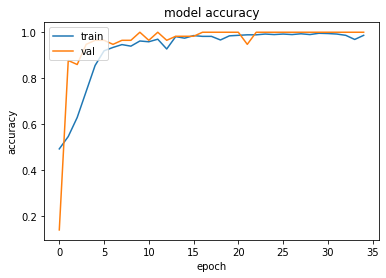

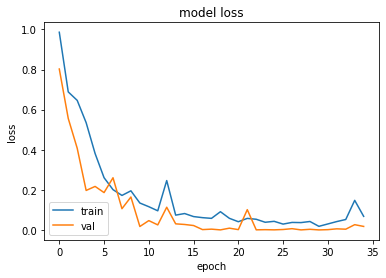

In [33]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
fig.savefig(filepath +'_history_acc.jpg')
fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')
fig.savefig(filepath +'_history_loss.jpg')

## 讀取訓練好的模型

In [34]:
model = load_model(filepath + '_val_loss_best.hdf5')

## 混淆矩陣

In [35]:
# 驗證集 df_val
count = 0
y_pred=[]
y_true=[]
for i in tqdm(range(df_val.shape[0])):
    img_name = df_val.iloc[i][1]
    ground_truth = df_val.iloc[i][0] # PASS:0
    img_path = os.path.join('./DAGM_KaggleUpload/Class6/Train/',img_name)
    cvimg = cv2.imread(img_path)
    img = cv2.cvtColor(cvimg,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224)).reshape(1,224,224,3)
    pred_probs = model.predict_on_batch(preprocess_input(img))
    y_pred.append(np.argmax(pred_probs[0]))
    y_true.append(ground_truth)
    if np.argmax(pred_probs[0]) != ground_truth:    # 若預測結果與真實標籤不同，列印出機率與檔名
        print(img_name)
        print(pred_probs[0])    

100%|██████████| 57/57 [00:02<00:00, 25.75it/s]


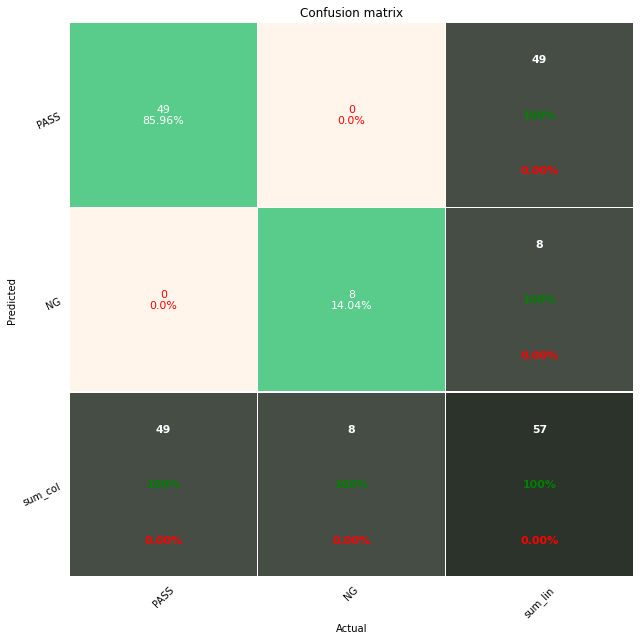

In [36]:
robust_confusion_matrix(y_test=y_true, predictions=y_pred,
                        filepath='./'+'val_',label=label.keys())

In [37]:
#計算統計指標
from sklearn.metrics import classification_report
report = classification_report(y_pred, y_true)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        49
           1       1.00      1.00      1.00         8

    accuracy                           1.00        57
   macro avg       1.00      1.00      1.00        57
weighted avg       1.00      1.00      1.00        57



## 測試集結果

In [38]:
df = pd.read_table('./DAGM_KaggleUpload/Class6/Test/Label/Labels.txt',sep='\t',header=0, names=['NG','img_name','0','NG_label','NaN'])
df

,NG,img_name,0,NG_label,NaN
1,0,0001.PNG,0,0,NaN
2,0,0002.PNG,0,0,NaN
3,0,0003.PNG,0,0,NaN
4,0,0004.PNG,0,0,NaN
5,0,0005.PNG,0,0,NaN
...,...,...,...,...,...
571,0,0571.PNG,0,0,NaN
572,0,0572.PNG,0,0,NaN
573,0,0573.PNG,0,0,NaN
574,0,0574.PNG,0,0,NaN


In [39]:
df_test = df[['NG', 'img_name']]
df_test

,NG,img_name
1,0,0001.PNG
2,0,0002.PNG
3,0,0003.PNG
4,0,0004.PNG
5,0,0005.PNG
...,...,...
571,0,0571.PNG
572,0,0572.PNG
573,0,0573.PNG
574,0,0574.PNG


In [40]:
# 測試集 df_test
count = 0
y_pred=[]
y_true=[]
for i in tqdm(range(df_test.shape[0])):
    img_name = df_test.iloc[i][1]
    ground_truth = df_test.iloc[i][0] # PASS:0
    img_path = os.path.join('./DAGM_KaggleUpload/Class6/Test/',img_name)
    cvimg = cv2.imread(img_path)
    img = cv2.cvtColor(cvimg,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224)).reshape(1,224,224,3)
    pred_probs = model.predict_on_batch(preprocess_input(img))
    y_pred.append(np.argmax(pred_probs[0]))
    y_true.append(ground_truth)
    if np.argmax(pred_probs[0]) != ground_truth:    # 若預測結果與真實標籤不同，列印出機率與檔名
        print(img_name)
        print(pred_probs[0])

100%|██████████| 575/575 [00:09<00:00, 58.98it/s]


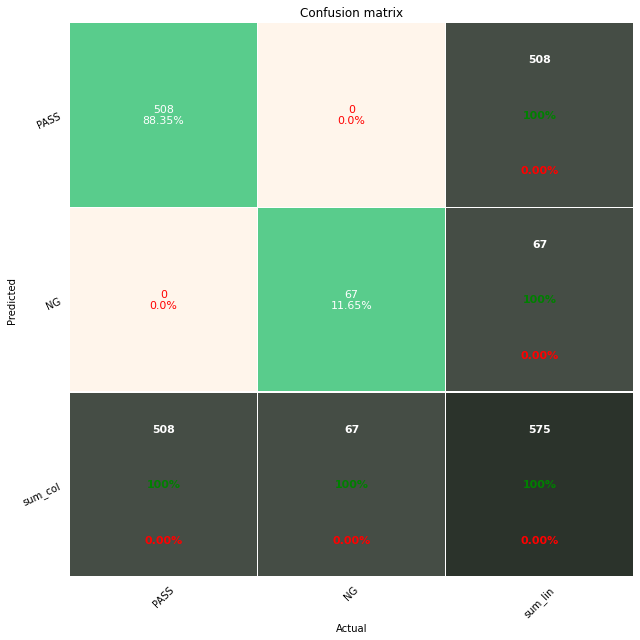

In [41]:
robust_confusion_matrix(y_test=y_true, predictions=y_pred,
                        filepath='./'+'test_',label=label.keys())

In [42]:
#計算統計指標
from sklearn.metrics import classification_report
report = classification_report(y_pred, y_true)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       508
           1       1.00      1.00      1.00        67

    accuracy                           1.00       575
   macro avg       1.00      1.00      1.00       575
weighted avg       1.00      1.00      1.00       575

